In [1]:
import geopandas
import pandas as pd
import numpy as np

from tqdm import tqdm

from shapely.geometry import Point, box
from shapely.strtree import STRtree
from shapely.ops import nearest_points

from litecoder.models import WOFLocality

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('seaborn-muted')

In [3]:
rows = []
for loc in WOFLocality.query.filter(WOFLocality.country_iso=='US'):
    rows.append((loc.wof_id, loc.name, loc.us_state_abbr, loc.longitude, loc.latitude, loc.population))
    
df = pd.DataFrame(rows, columns=('wof_id', 'name', 'state', 'longitude', 'latitude', 'population'))

In [4]:
df['point'] = list(zip(df.longitude, df.latitude))
df['point'] = df['point'].apply(Point)

In [5]:
gdf = geopandas.GeoDataFrame(df, geometry='point')

In [6]:
gdf.head(10)

,wof_id,name,state,longitude,latitude,population,point
0,85897411,Valley Head,AL,-85.621354,34.557517,558.0,POINT (-85.621354 34.557517)
1,85897417,Sylvania,AL,-85.804804,34.562109,1837.0,POINT (-85.804804 34.562109)
2,85897421,Shiloh,AL,-85.877994,34.463763,274.0,POINT (-85.877994 34.463763)
3,85897425,Rainsville,AL,-85.843520,34.493782,4948.0,POINT (-85.84352 34.493782)
4,85897429,Powell,AL,-85.897879,34.532534,NaN,POINT (-85.897879 34.532534)
5,85897435,Pine Ridge,AL,-85.780673,34.448890,282.0,POINT (-85.78067299999999 34.44889)
6,85897439,Mentone,AL,-85.584222,34.566291,360.0,POINT (-85.584222 34.566291)
7,85897443,Lakeview,AL,-85.975703,34.391629,143.0,POINT (-85.975703 34.391629)
8,85897447,Tuscumbia,AL,-87.703381,34.721209,8423.0,POINT (-87.70338099999999 34.721209)
9,85897453,Geraldine,AL,-86.003706,34.357721,896.0,POINT (-86.00370599999999 34.357721)


In [7]:
gdf.population = gdf.population.fillna(gdf.population.median())

3098


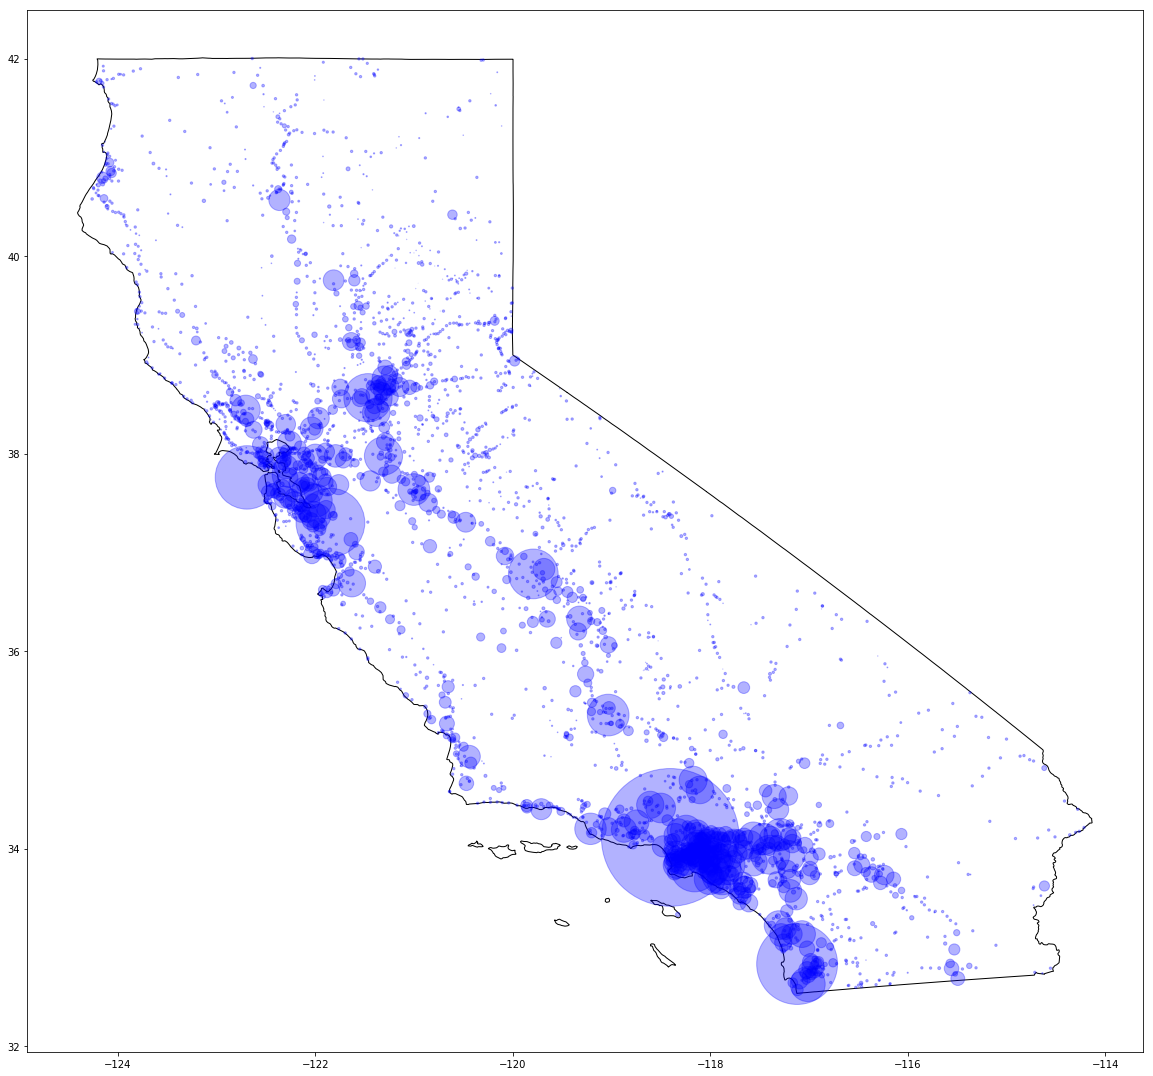

In [8]:
state = 'CA'

states = geopandas.read_file('../data/cb_2017_us_state_5m/cb_2017_us_state_5m.shp')

ax = states[states.STUSPS==state].plot(color='white', edgecolor='black', figsize=(20,20))

sdf = gdf[gdf.state==state]
print(len(sdf))

sdf.plot(ax=ax, color='blue', markersize=sdf['population'] / 200, alpha=0.3)
plt.show()

In [9]:
points = []
for r in gdf.itertuples():
    p = Point(r.point)
    p.wof_id = r.wof_id
    points.append(p)

In [10]:
idx = STRtree(points)

In [11]:
dupes = set()
for r in tqdm(gdf.itertuples()):
    
    center = WOFLocality.query.get(r.wof_id)
    
    # Within ~10km.
    close = idx.query(r.point.buffer(0.1))
    close_ids = [p.wof_id for p in close if p.wof_id != r.wof_id]
    
    if not close_ids:
        continue

    rows = WOFLocality.query.filter(WOFLocality.wof_id.in_(close_ids)).all()
    
    for row in rows:
        if row.name == center.name and row.completeness > center.completeness:
            dupes.add(r.wof_id)
            break

54727it [02:52, 316.83it/s]


In [13]:
len(dupes)

797

In [14]:
1141909337 in dupes

True

In [16]:
1141909161 in dupes

True

In [17]:
85970739 in dupes

False